In [2]:
import numpy as np
from scipy.special import gammaln, digamma, polygamma  
import matplotlib.pyplot as plt

In [4]:
# generate N samples of x_n = Gam(alpha, beta)
def generate_data(N: int, alpha: float, beta: float) -> np.ndarray:
    return np.random.gamma(shape=alpha, scale = beta, size=N)

In [5]:
def negloglikelihood(alpha: np.ndarray, beta: np.ndarray, x_mean: float, log_x_mean: float) -> float:
    return gammaln(alpha) + alpha * np.log(beta) - (alpha -1) * log_x_mean + x_mean / beta

def grad_loglikelihood(alpha: float, beta: float, x_mean: float, log_x_mean: float) -> np.ndarray:
    d_alpha = digamma(alpha) + np.log(beta) - log_x_mean
    d_beta =  alpha / beta - x_mean / beta**2
    return np.array([d_alpha, d_beta])

def fisher_inv(alpha: float, beta: float) -> np.ndarray:
    d_psi = polygamma(1, alpha)
    denom = alpha * d_psi - 1
    return (1 / denom) * np.array([
        [alpha, -beta],
        [-beta, d_psi * beta**2] 
    ])

def run_gd(T: int, x_mean: float, log_x_mean: float, alpha: float, beta: float, step: float) -> tuple[np.ndarray, list]:
    theta = np.array([alpha, beta])
    theta_list = []

    for t in range(T):
        d_theta = grad_loglikelihood(theta[0], theta[1], x_mean, log_x_mean)
        theta -= step * d_theta

        theta = np.maximum(theta, 1e-6)
        theta_list.append(theta.copy())
    return theta, theta_list

def run_natural_grad(T: int, x_mean: float, log_x_mean: float, alpha: float, beta: float, step: float) -> tuple[np.ndarray, list]:
    theta = np.array([alpha, beta])
    theta_list = []

    for t in range(T):
        d_theta = grad_loglikelihood(theta[0], theta[1], x_mean, log_x_mean)
        F_inv = fisher_inv(theta[0], theta[1])

        natural_grad = F_inv @ d_theta
        theta -= step * natural_grad

        theta = np.maximum(theta, 1e-6)
        theta_list.append(theta.copy())
    return theta, theta_list

In [15]:
# plots and such

def plot_theta(theta_gd: np.ndarray, theta_ngd: np.ndarray, title: str, save=False) -> None:
    alphas_gd = theta_gd[:, 0]
    betas_gd = theta_gd[:, 1]
    alphas_ngd = theta_ngd[:, 0]
    betas_ngd = theta_ngd[:, 1]
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot alpha trajectory
    ax[0].plot(alphas_gd, linewidth=2, label=r"$\alpha_{gd}$")
    ax[0].plot(alphas_ngd, linewidth=2, label=r"$\alpha_{ngd}$")
    ax[0].set_xlabel("Iterations")
    ax[0].set_ylabel(r"$\alpha$")
    ax[0].set_title(r"Evolution of $\alpha$")
    ax[0].grid(True)

    # Plot beta trajectory
    ax[1].plot(betas_gd, linewidth=2, label=r"$\beta_{gd}$")
    ax[1].plot(betas_ngd, linewidth=2, label=r"$\beta_{ngd}$")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel(r"$\beta$")
    ax[1].set_title(r"Evolution of $\beta$")
    ax[1].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.legend()
    plt.tight_layout(pad=1.5)

    if save:
        plt.savefig("alpha_beta_comp.png", dpi=300)

    plt.show()

def plot_theta_separate(theta_gd: np.ndarray, theta_ngd: np.ndarray, save: bool = False) -> None:
    # Extract coordinates
    alphas_gd = theta_gd[:, 0]
    betas_gd  = theta_gd[:, 1]

    alphas_ngd = theta_ngd[:, 0]
    betas_ngd  = theta_ngd[:, 1]

    # plot alphas
    plt.figure(figsize=(6, 4))
    plt.plot(alphas_gd, linewidth=2, label=r"$\alpha_{\text{GD}}$")
    plt.plot(alphas_ngd, linewidth=2, label=r"$\alpha_{\text{NGD}}$")
    plt.axhline(3, color="red", linestyle="--", linewidth=2, label=r"$\alpha^\ast$")
    plt.xlabel("Iteration", size=20)
    plt.ylabel(r"$\alpha$", size=20)
    plt.title(r"Evolution of $\alpha$", size=20)
    plt.grid(True)
    plt.legend()
    plt.tight_layout(pad=1.5)

    if save:
        plt.savefig("alpha_comp.png", dpi=300)

    plt.show()

    # plot betas 
    plt.figure(figsize=(6, 4))
    plt.plot(betas_gd, linewidth=2, label=r"$\beta_{\text{GD}}$")
    plt.plot(betas_ngd, linewidth=2, label=r"$\beta_{\text{NGD}}$")
    plt.axhline(2, color="red", linestyle="--", linewidth=2, label=r"$\beta^\ast$")
    plt.xlabel("Iteration", size=20)
    plt.ylabel(r"$\beta$", size=20)
    plt.title(r"Evolution of $\beta$", size=20)
    plt.grid(True)
    plt.legend()
    plt.tight_layout(pad=1.5)

    if save:
        plt.savefig("beta_comp.png", dpi=300)

    plt.show()

def plot_neg_log(x_mean: float, log_x_mean: float, theta_gd: np.ndarray, theta_ngd: np.ndarray, save: bool = False) -> None:
    # Extract coordinates
    alphas_gd = theta_gd[:, 0]
    betas_gd  = theta_gd[:, 1]

    neg_logs_gd = negloglikelihood(alphas_gd, betas_gd, x_mean, log_x_mean)

    alphas_ngd = theta_ngd[:, 0]
    betas_ngd  = theta_ngd[:, 1]

    neg_logs_ngd = negloglikelihood(alphas_ngd, betas_ngd, x_mean, log_x_mean)

    # plot alphas
    plt.figure(figsize=(6, 4))
    plt.plot(neg_logs_gd, linewidth=2, label=r"$L_{\text{GD}}$")
    plt.plot(neg_logs_ngd, linewidth=2, label=r"$L_{\text{NGD}}$")
    plt.xlabel("Iteration", size=20)
    plt.ylabel(r"$L(\alpha, \beta)$", size=20)
    plt.title(r"Loss Comparison", size=20)
    plt.grid(True)
    plt.legend()
    plt.tight_layout(pad=1.5)

    if save:
        plt.savefig("neg_log_lik_comp.png", dpi=300)

    plt.show()

    plt.show()

True theta: 3.0, 2.0
Gradient estimate:  1.5426249336752798, 4.622650500680204
Natural gradient estimate:  3.022972506219218, 1.9877282176321027


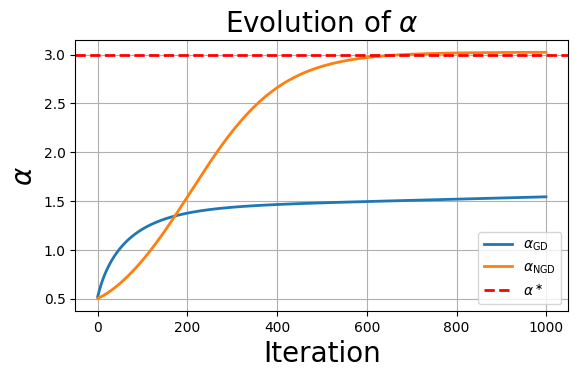

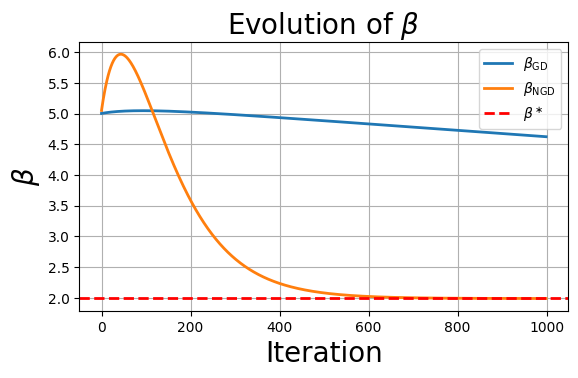

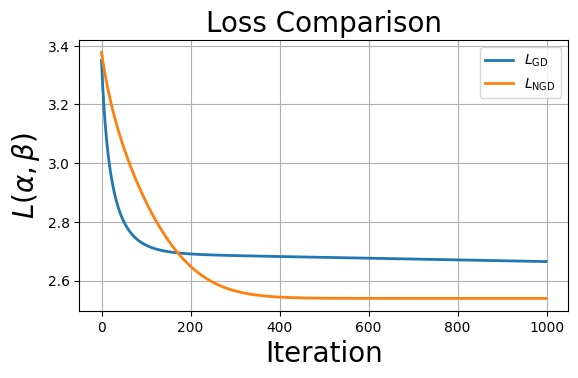

In [16]:
# main loop hehe


N = 1000

# true theta
alpha_true = 3.0
beta_true = 2.0

x = generate_data(N, alpha_true, beta_true)

# calculate sufficient statistics
x_mean = np.mean(x)
log_x_mean = np.mean(np.log(x))

# bad initial guess
alpha_0 = 0.5
beta_0 = 5.0

# step size
step = 0.01

# run gradient descent
T = 1000
theta_gd, theta_gd_list = run_gd(T, x_mean, log_x_mean, alpha_0, beta_0, step)

# natural gradient
theta_ngd, theta_ngd_list = run_natural_grad(T, x_mean, log_x_mean, alpha_0, beta_0, step)

print(f"True theta: {alpha_true}, {beta_true}")
print(f"Gradient estimate:  {theta_gd[0]}, {theta_gd[1]}")
print(f"Natural gradient estimate:  {theta_ngd[0]}, {theta_ngd[1]}")

#plot_theta(np.array(theta_gd_list), np.array(theta_ngd_list), "Comparison between natural gradient and gradient")
plot_theta_separate(np.array(theta_gd_list), np.array(theta_ngd_list), save=True)

plot_neg_log(x_mean, log_x_mean, np.array(theta_gd_list), np.array(theta_ngd_list), save=True)
